In [1]:
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
import json

# Load Data and preparing

## Data Class

In [2]:
class Category:
    ELECTRONICS = "ELECTRONICS"
    BOOKS = "BOOKS"
    CLOTHING = "CLOTHING"
    GROCERY = "GROCERY"
    PATIO = "PATIO"
    
class Sentiment:
    POSITIVE = "POSITIVE"
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"
    
class Review:
    def __init__(self, category, text, score):
        self.category = category
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.score <= 2:
            return Sentiment.NEGATIVE
        elif self.score == 3:
            return Sentiment.NEUTRAL
        else:
            return Sentiment.POSITIVE

class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_x(self, vetorizer):
        return vectorizer.transform(self.get_text())
    
    def get_y(self):
        return [x.sentiment for x in self.reviews]
    
    def get_category(self):
        return [x.category for x in self.reviews]
    
    def evenly_distribute(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        positive_shrunk = positive[:len(negative)]
        print(len(positive_shrunk))
        self.reviews = negative + positive_shrunk
        random.shuffle(self.reviews)
        print(self.reviews[0])
        

## Load Data

In [3]:
file_names = ['./data/Electronics_small.json', './data/Books_small.json', './data/Clothing_small.json', './data/Grocery_small.json', './data/Patio_small.json']
file_categories = [Category.ELECTRONICS, Category.BOOKS, Category.CLOTHING, Category.GROCERY, Category.PATIO]

reviews = []
for i in zip(file_names, file_categories):
    file, category = i
    with open(file) as f:
        for line in f:
            review_json = json.loads(line)
            review = Review(category, review_json['reviewText'], review_json['overall'])
            reviews.append(review)
            


In [4]:
reviews[0].sentiment

'POSITIVE'

## Data Prep

In [5]:
train, test = train_test_split(reviews, test_size = 0.33, random_state = 42)

In [6]:
train_container = ReviewContainer(train)
test_container = ReviewContainer(test)

In [7]:
# train_container.evenly_distribute()
# test_container.evenly_distribute()

In [8]:
corpus = train_container.get_text()
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)



TfidfVectorizer()

In [9]:
train_x = train_container.get_x(vectorizer)
train_y = train_container.get_category()

test_x = test_container.get_x(vectorizer)
test_y = test_container.get_category()


# Classification

## SVM

In [12]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

#clf_svc = make_pipeline(SVC(C = 26, kernel = 'linear', gamma = 'auto')) # in this situation there is 
clf_svc = SVC(C = 16, kernel = 'linear', gamma = 'auto')                                                                      # no need for creating a pipeline
clf_svc.fit(train_x, train_y)

SVC(C=16, gamma='auto', kernel='linear')

In [14]:
test_set = ['great for my wedding', "loved it in my garden", 'good computer']
new_test = vectorizer.transform(test_set)

clf_svc.predict(new_test)

array(['CLOTHING', 'PATIO', 'ELECTRONICS'], dtype='<U11')

## Gausssian Naive Bayes

In [16]:
from sklearn.naive_bayes import GaussianNB

gnb = make_pipeline(GaussianNB())
gnb.fit(train_x.todense(), train_y)

Pipeline(steps=[('gaussiannb', GaussianNB())])

# Performance

## SVM

In [20]:
y_pred = clf_svc.predict(test_x)

f1_score(test_y, y_pred, average = None)

array([0.95111111, 0.89323308, 0.88567294, 0.89891135, 0.91693291])

## Gaussian Naive Bayes

In [21]:
y_pred = gnb.predict(test_x.toarray())

f1_score(test_y, y_pred, average = None)

array([0.84161491, 0.76725522, 0.7994012 , 0.85139319, 0.79554937])

### By looking at the results we can say that svm performs well.

# Tuning the model

In [26]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ('linear', 'rbf'), 'C': [0.1, 1, 8, 16, 32]}
svc = SVC()
clf = GridSearchCV(svc, parameters, cv = 5)
clf.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 8, 16, 32], 'kernel': ('linear', 'rbf')})

In [27]:
clf.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(),
 'n_jobs': None,
 'param_grid': {'kernel': ('linear', 'rbf'), 'C': [0.1, 1, 8, 16, 32]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [29]:
y_pred = clf.predict(test_x)

f1_score(test_y, y_pred, average = None)

array([0.95223881, 0.8983308 , 0.90201729, 0.9202454 , 0.9216    ])

# Pickle model

## Save classifier

In [35]:
import pickle

with open('./models/category_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)
    
with open('./models/categry_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

## Load Classifier

In [ ]:
import pickle 

with open('./models/category_classifier.pkl', 'rb') as f:
    clf = pickle.load(f)

with open('./models/category_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

In [36]:
test_set = ['very quick speeds', "loved the necklace", 'bad']
new_test = vectorizer.transform(test_set)

clf.predict(new_test)

array(['ELECTRONICS', 'CLOTHING', 'GROCERY'], dtype='<U11')

# Confusion Matrix

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

y_pred = clf.predict(test_x)

labels = [Category.ELECTRONICS, Category.BOOKS, Category.CLOTHING, Category.GROCERY, Category.PATIO]

cm = confusion_matrix(test_y, y_pred, labels = labels)
df_cm = pd.DataFrame(cm, index = labels, columns = labels)


In [44]:
df_cm.head()

,ELECTRONICS,BOOKS,CLOTHING,GROCERY,PATIO
ELECTRONICS,313,2,16,3,7
BOOKS,8,319,6,6,3
CLOTHING,18,2,296,7,4
GROCERY,4,3,10,300,8
PATIO,10,2,4,11,288


<AxesSubplot:>

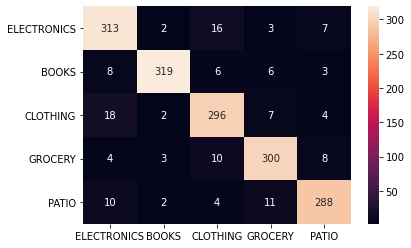

In [45]:
sn.heatmap(df_cm, annot = True, fmt="d")

In [46]:
cm

array([[313,   2,  16,   3,   7],
       [  8, 319,   6,   6,   3],
       [ 18,   2, 296,   7,   4],
       [  4,   3,  10, 300,   8],
       [ 10,   2,   4,  11, 288]], dtype=int64)